In [1]:
!pip install d2l==0.17.2

Model Selection, Underfitting, and Overfitting

In [2]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

Generating the dataset

In [3]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

In [5]:
features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 0.7447123],
        [-0.7323409]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.0000000e+00,  7.4471229e-01,  2.7729821e-01,  6.8835802e-02,
          1.2815717e-02,  1.9088045e-03,  2.3691836e-04,  2.5205147e-05,
          2.3463228e-06,  1.9414840e-07,  1.4458470e-08,  9.7885466e-10,
          6.0747095e-11,  3.4799314e-12,  1.8511055e-13,  9.1902736e-15,
          4.2775688e-16,  1.8738577e-17,  7.7526945e-19,  3.0386984e-20],
        [ 1.0000000e+00, -7.3234087e-01,  2.6816159e-01, -6.5461896e-02,
          1.1985106e-02, -1.7554366e-03,  2.1426301e-04, -2.2416223e-05,
          2.0520397e-06, -1.6697695e-07,  1.2228404e-08, -8.1412371e-10,
          4.9684673e-11, -2.7989321e-12,  1.4641231e-13, -7.1482483e-15,
          3.2718466e-16, -1.4094747e-17,  5.7345330e-19, -2.2103332e-20]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.386578 , 2.7901235], dtype=

Training and testing the model

In [6]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [7]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

[Third-Order Polynomial Function Fitting (Normal)]

weight: [[ 4.9842134  1.3417684 -3.424146   5.1627717]]


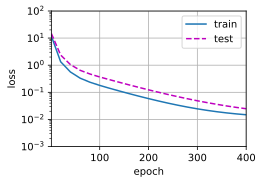

In [8]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

[Linear Function Fitting (Underfitting)]

weight: [[3.6217628 3.4218774]]


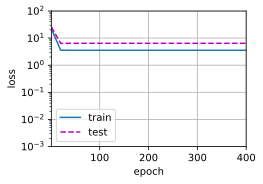

In [9]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

[Higher-Order Polynomial Function Fitting (Overfitting)]

weight: [[ 4.961305    1.2499864  -3.2511833   5.3310976  -0.72728103  0.84946513
   0.48278016  0.11681695  0.15909883  0.44111788 -0.39354032  0.19817202
  -0.3531899   0.14168021 -0.07393561 -0.1298928   0.07317483 -0.37453127
  -0.38052386 -0.47115672]]


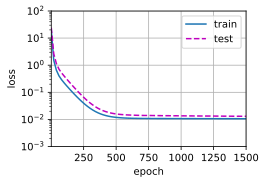

In [10]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)